# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics

import codecs
import glob
import json
import numpy as np

from tqdm import tqdm
import sys

from PIL import Image, ImageOps
import cv2 as cv

# Library for the Neural Network
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from keras import backend as K 

# Default image sizes
default_x = 100
default_y = 50


# Load data, process and save as numpy zip

{'x': 0.12075471698113208, 'y': 0.09904153354632587} 313
(313, 530, 3)


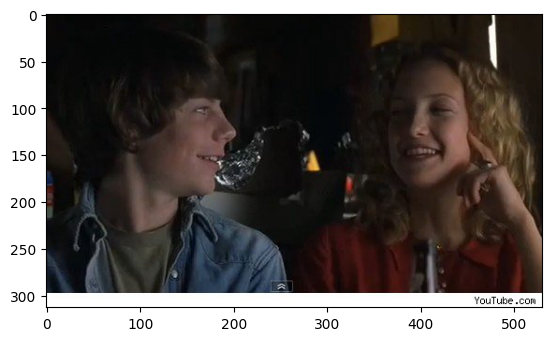

In [2]:
images_to_train = np.load("images.npy", allow_pickle=True)

image_det = images_to_train[200]
img = image_det[0] 
img = Image.fromarray(img, 'RGB')
up_point = image_det[1][0]["points"][0]
down_point = image_det[1][0]["points"][1]
shape_x = image_det[0].shape[1]
shape_y = image_det[0].shape[0]
print(up_point, shape_y)
print (image_det[0].shape)


plt.imshow(img)

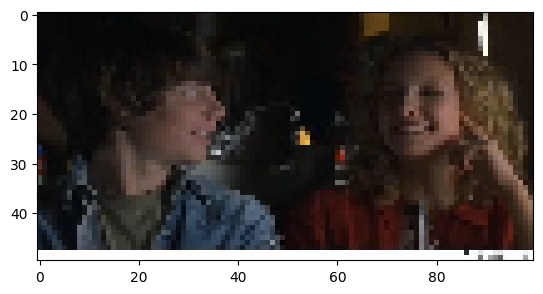

In [3]:
image_adjusted = np.uint8(cv.resize(np.uint8(img), (default_x, default_y)))
plt.imshow(image_adjusted)

In [23]:
def create_masks_for_training():
    global default_x
    global default_y
    
    X = np.empty((0, default_y, default_x, 3))
    y = np.empty((0, default_y, default_x, 3))
    for image in tqdm(images_to_train):
        # image = images_to_train[2]
        shape_x = image[0].shape[1]
        shape_y = image[0].shape[0]
        image_mask = np.zeros((shape_y, shape_x, 3)) # set background to 0
        for bbox in image[1]:
            up_point = bbox["points"][0]
            down_point = bbox["points"][1]
            image_mask[int(up_point['y']*shape_y):int(down_point['y']*shape_y), int(up_point['x']*shape_x):int(down_point['x']*shape_x), 0] = 255

        image_adjusted = np.uint8(cv.resize(np.uint8(image[0]), (default_x, default_y)))
        image_mask = np.uint8(cv.resize(np.uint8(image_mask), (default_x, default_y)))
        if (image_adjusted.shape != (default_y, default_x, 3)):
            continue
        
        image_adjusted = np.reshape(image_adjusted, (1, default_y, default_x, 3))
        image_mask = np.reshape(image_mask, (1, default_y, default_x, 3))

        # print (image_adjusted.shape, image_mask.shape)
        X = np.vstack((X, image_adjusted))
        y = np.vstack((y, image_mask))
        
    return X,y

X, y = create_masks_for_training()

100%|██████████| 409/409 [00:09<00:00, 44.52it/s]


In [24]:
np.savez('training_data_processed5.npz', train=X, train_labels=y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(397, 50, 100, 3) (397, 50, 100, 3)


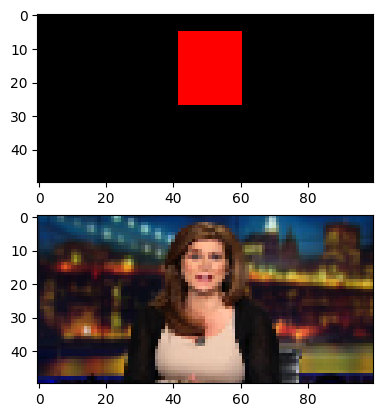

In [25]:
print (X.shape, y.shape)
fig = plt.figure()
fig.add_subplot(2,1,1)

plt.imshow(y[100], cmap='Greys')
fig.add_subplot(2,1,2)

plt.imshow(Image.fromarray(np.uint8(X[100]), 'RGB'))

# Load the processed training images

In [26]:
def load_processed_data():
    # load training data

    X = np.empty((0, default_y, default_x, 3))
    y = np.empty((0, default_y* default_x* 1))
    training_data = ['training_data_processed4.npz']
    training_data.append('training_data_processed5.npz')
    print (training_data)

    for single_npz in training_data:
        with np.load(single_npz) as data:
            train = data['train']
            train_labels = data['train_labels']
        X = np.vstack((X, train))
        del train
        
        for label in tqdm(train_labels):             
            img = cv.cvtColor(label.astype('uint8'), cv.COLOR_BGR2GRAY)
            y = np.vstack((y, img.ravel()))
        del train_labels
    return X, y

X, y = load_processed_data()

['training_data_processed4.npz', 'training_data_processed5.npz']


100%|██████████| 397/397 [00:02<00:00, 159.87it/s]


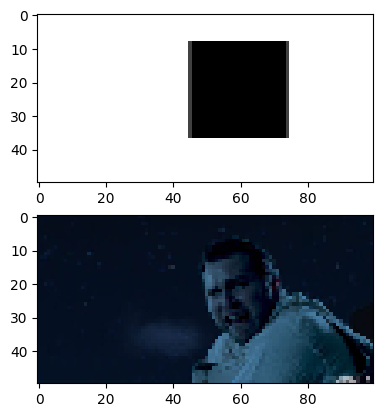

In [27]:
img_nr = 700
img = np.uint8(X[img_nr])
img_label = np.uint8(y[img_nr])
img_label = img_label.reshape(default_y, default_x)

fig = plt.figure()
fig.add_subplot(2,1,1)

plt.imshow(img_label, cmap='Greys')
fig.add_subplot(2,1,2)

plt.imshow(img)

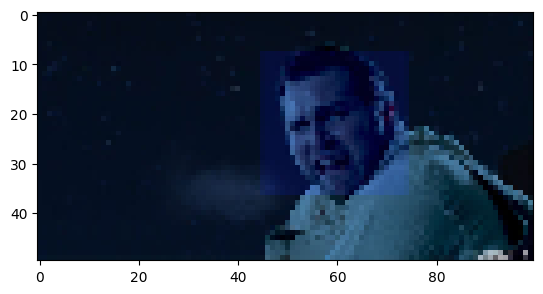

In [28]:
# Blending the images with 0.3 and 0.7 
test_img = img
pred = img_label
r = cv.split(test_img)[0]
g = cv.split(test_img)[1]
b = cv.split(test_img)[2]
b = b + pred
img = cv.merge([r,g,b])
plt.imshow(img)

In [29]:
print (np.amax(X[0]))
print (np.amax(y[0]))

X = (X/(float(np.amax(X[0]))))
y = (y/(float(np.amax(y))))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

print (np.amax(X[0]))
print (np.amax(y[0]))

255.0
29.0
1.0
1.0


In [30]:
del X
del y